# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

#### Common imports

In [14]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#### Part (1)

In [16]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [17]:
# write your code here for part estimating essential matrices
def fit_fundamental(matches):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    """
    # <YOUR CODE>
    # Extract point coordinates
    x1 = matches[:, 0]
    y1 = matches[:, 1]
    x2 = matches[:, 2]
    y2 = matches[:, 3]
    
    # Assemble the homogeneous linear system
    A = np.column_stack([
        x1*x2, y1*x2, x2, 
        x1*y2, y1*y2, y2, 
        x1, y1, np.ones_like(x1)
    ])
    
    # Solve for the nullspace of A using SVD
    _, _, V = np.linalg.svd(A)
    F = V[-1, :].reshape((3, 3))
    
    # Enforce the rank-2 constraint on F
    u, s, vt = np.linalg.svd(F)
    s[-1] = 0
    F = u @ np.diag(s) @ vt
    
    return F / F[2, 2]

def fit_fundamental_normalized(matches):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """
    # <YOUR CODE>
    mean = np.mean(matches, axis=0)
    std = np.std(matches, axis=0)
    T1 = np.array([[1/std[0], 0, -mean[0]/std[0]],
                   [0, 1/std[1], -mean[1]/std[1]],
                   [0, 0, 1]])
    T2 = np.array([[1/std[2], 0, -mean[2]/std[2]],
                   [0, 1/std[3], -mean[3]/std[3]],
                   [0, 0, 1]])
    
    # Normalize point coordinates
    x1 = (matches[:, 0] - mean[0]) / std[0]
    y1 = (matches[:, 1] - mean[1]) / std[1]
    x2 = (matches[:, 2] - mean[2]) / std[2]
    y2 = (matches[:, 3] - mean[3]) / std[3]
    
    # Assemble the normalized point correspondences
    matches_norm = np.column_stack([x1, y1, x2, y2])
    
    # Compute the fundamental matrix using the normalized point correspondences
    F_norm = fit_fundamental(matches_norm)
    
    # Denormalize the fundamental matrix
    F = T2.T @ F_norm @ T1
    
    return F / F[2, 2]

Fundamental Unnormalized
[[ 1.32546895e-06 -1.36852466e-05  6.83862987e-04]
 [ 2.88625175e-05 -2.66854091e-07 -4.09703775e-02]
 [-5.63235250e-03  3.73349826e-02  1.00000000e+00]]
library: residual in frame 2 (non-normalized method) =  0.17921336681147462
library: residual in frame 1 (non-normalized method) =  0.14912309939434457
library: residual combined   (non-normalized method) =  0.1641682331029096
Fundamental Normalized
[[ 1.86520131e-07 -3.82943867e-06  5.65229482e-04]
 [ 2.22767397e-05  2.16768623e-07 -4.11451100e-02]
 [-5.30028152e-03  3.69650848e-02  1.00000000e+00]]
library: residual in frame 2 (normalized method) =  0.060334458479578496
library: residual in frame 1 (normalized method) =  0.05484509861965783
library: residual combined   (normalized method) =  0.057589778549618165


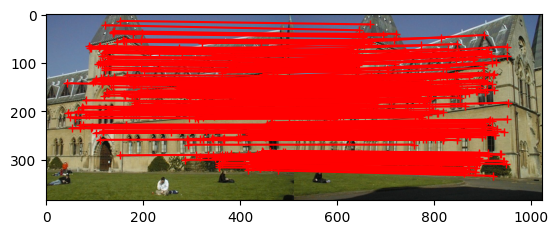

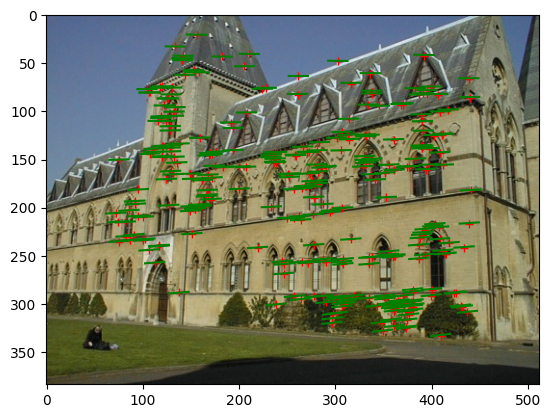

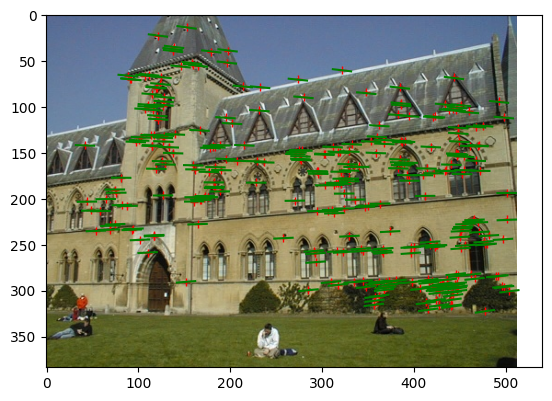

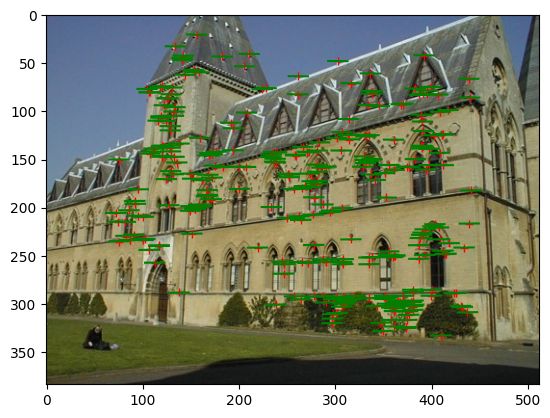

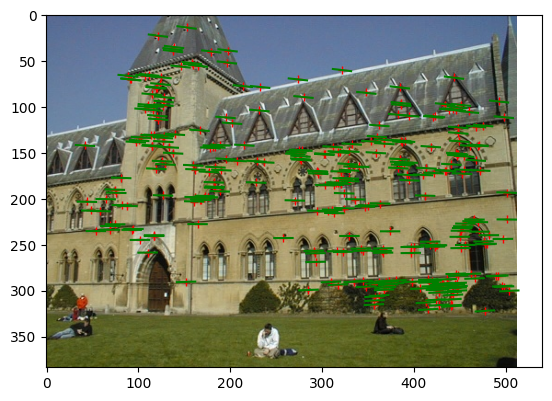

In [18]:
# Fundamental matrix estimation
name = 'library' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('Fundamental Unnormalized')
print(F)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
print('Fundamental Normalized')
print(F)
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

#### Part (2)

In [19]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration (lab)
def camera_calibration(points, projection):
    """
    write your code to compute camera matrix
    """
    # <YOUR CODE>
    # points = np.hstack((points, np.ones((points.shape[0], 1))))
    # projection = np.hstack((projection, np.ones((projection.shape[0], 1))))

    # # Construct the matrix A
    # N = points.shape[0]
    # A = np.zeros((2*N, 12))
    # for i in range(N):
    #     x, y, z, _ = points[i]
    #     u, v, _ = projection[i]
    #     A[2*i] = np.array([x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u])
    #     A[2*i+1] = np.array([0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v])

    # # Solve for the camera matrix using SVD
    # _, _, V = np.linalg.svd(A)
    # P = V[-1, :].reshape((3, 4))

    # return P / P[2, 3]
    N = points.shape[0]
    points = np.concatenate((points, np.ones((N, 1))), axis=1)
    A = np.zeros((2*N, 12))
    zeros = np.zeros((4, ))
    ones = np.ones((4, ))
    for i in range(N):
        x1, y1 = projection[i]
        flatten = np.array([*zeros, *ones, *(-y1*ones), *ones, *zeros, *(-x1*ones)])
        A[2*i:2*i + 2] = (flatten.reshape(6, 4)*points[i]).reshape(2, 12)
    U, S, V = np.linalg.svd(A, full_matrices=False)
    P = V[-1, :].reshape(3, 4)
    return P


# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./lab_3d.txt')
matches = np.loadtxt('./lab_matches.txt')

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(pts_3d, matches[:, :2])
lab2_proj = camera_calibration(pts_3d, matches[:, 2:])
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lab1_res = evaluate_points(lab1_proj, matches[:, :2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
_, lab2_res = evaluate_points(lab2_proj, matches[:, 2:], pts_3d)
print('residual in lab2:', lab2_res)

lab 1 camera projection
[[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]]

lab 2 camera projection
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
residuals between the observed 2D points and the projected 3D points:
residual in lab1: 13.545832894768449
residual in lab2: 15.544953471723453


In [20]:
lib1_proj = np.loadtxt('./library1_camera.txt')
lib2_proj = np.loadtxt('./library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]


#### Part (3)

In [21]:
# Write your code here for computing camera centers
def calc_camera_center(P):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    # <YOUR CODE>
    M = P[:, :3]
    t = P[:, 3]
    A = np.hstack((M, -t.reshape(-1, 1)))
    _, _, V = np.linalg.svd(A)
    C = V[-1, :3] / V[-1, 3]
    C *= -1
    return C
# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(lab1_proj)
lab2_c = calc_camera_center(lab2_proj)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(lib1_proj)
lib2_c = calc_camera_center(lib2_proj)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)

lab1 camera center [305.83276769 304.20103826  30.13699243]
lab2 camera center [303.10003925 307.18428016  30.42166874]
library1 camera center [  7.28863053 -21.52118112  17.73503585]
library2 camera center [  6.89405488 -15.39232716  23.41498687]


#### Part (4)

Mean 3D reconstuction error for the lab data:  0.01332
2D reprojection error for the lab 1 data:  10.899446033014147
2D reprojection error for the lab 2 data:  1.5485148119181338
2D reprojection error for the library 1 data:  24.662071196868627
2D reprojection error for the library 2 data:  28.649537735261134


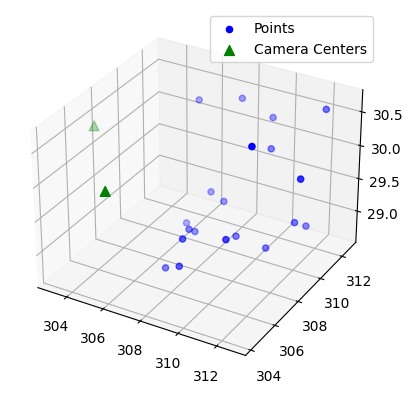

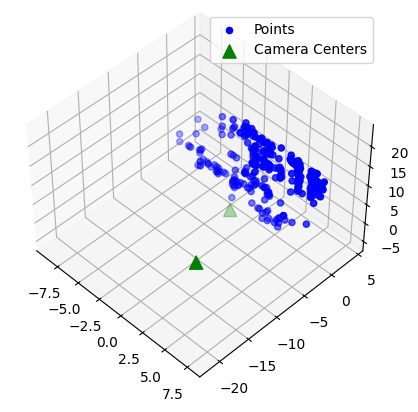

In [22]:
# Write your code here for triangulation
from mpl_toolkits.mplot3d import Axes3D
def triangulation(P1, P2, matches):
    """
    write your code to triangulate the points in 3D
    """
    # <YOUR CODE>
    matches = np.hstack((matches, np.ones((matches.shape[0], 1))))

    # Compute the triangulated points
    N = matches.shape[0]
    X = np.zeros((N, 3))
    for i in range(N):
        
        x1, y1, x2, y2 = matches[i][0],matches[i][1],matches[i][2],matches[i][3]
        A = np.vstack((
            y1 * P1[2] - P1[1],
            P1[0] - x1 * P1[2],
            y2 * P2[2] - P2[1],
            P2[0] - x2 * P2[2]
        ))
        _, _, V = np.linalg.svd(A)
        X[i, :] = V[-1, :3] / V[-1, 3]

    return X

def evaluate_points_3d(output, gt):
    """
    write your code to evaluate the triangulated 3D points
    """
    # <YOUR CODE>
    return np.linalg.norm(output - gt, axis=1)

# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./lab_matches.txt')
points_3d_gt = np.loadtxt('./lab_3d.txt')
points_3d_lab = triangulation(lab1_proj, lab2_proj, matches_lab) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(points_3d_lab, points_3d_gt) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, matches[:, :2], points_3d_lab)
_, res_2d_lab2 = evaluate_points(lab2_proj, matches[:, 2:], points_3d_lab)
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')

# triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./library_matches.txt')
points_3d_lib = triangulation(lib1_proj, lib2_proj, matches_lib) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, matches_lib[:, :2], points_3d_lib)
_, res_2d_lib2 = evaluate_points(lib2_proj, matches_lib[:, 2:], points_3d_lib)
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')

In [27]:
#Extra credits

In [33]:
import cv2
import scipy
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des


def get_best_matches(img1, img2, threshold = 0.03):
    #I choose the select  threshold, because this is easier..
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    matches = dist/ dist.max() < threshold 
    match_points = np.nonzero(matches)
    inliers = np.zeros((len(match_points[0]), 4))

    for i, match_idx in enumerate(zip(*match_points)):
        inliers[i] = [*kp1[match_idx[0]].pt, *kp2[match_idx[1]].pt]
        
    return inliers

def ransac(data, distance_threshold=2, outlier_ratio=0.2):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    # <YOUR CODE>
    p = 0.99
    s = 4
    e = outlier_ratio
    N = int(np.log(1 - p) / np.log(1 - e ** s))

    X = data[:, :2]
    X_match = data[:, 2:]
    X_h = np.ones((data.shape[0], 3))
    X_h[:, :2] = X

    best_h = None
    best_inliers = None
    best_residuals = None

    for i in range(N):
        # Sample s points from the data
        samples_idx = np.random.choice(data.shape[0], size=s, replace=False)
        samples = data[samples_idx]
        h = compute_homography(samples)
        h = h.reshape((3, 3))
        
        # Calculate inlier/outlier correspondences
        projected = np.dot(h, X_h.T)
        projected /= projected[-1, :]
        projected = projected[:2, :].T
        residuals = np.linalg.norm(projected - X_match, axis=1)
        inlier_mask = residuals <= distance_threshold
        outlier_mask = np.logical_not(inlier_mask)
        inliers = data[inlier_mask]
        residuals_inliers = residuals[inlier_mask]
        
        # If this is the best model found so far, store it
        if best_h is None or len(inliers) > len(best_inliers):
            best_h = compute_homography(inliers).reshape((3, 3))
            best_inliers = inliers
            best_residuals = residuals_inliers
            
        # Check if the number of outliers is below the threshold
        if len(outlier_mask) / len(data) < e:
            break

    if best_h is None:
        raise ValueError("Failed to find a good model!")

    return best_h, best_inliers, best_residuals

def compute_homography(matches):
    """
    write your code to compute homography according to the matches
    """
    # <YOUR CODE>
    num_matches = matches.shape[0]
    A = np.zeros((2*num_matches, 9))
    for i, match in enumerate(matches):
        x1, y1, x2, y2 = match
        A[2*i, :] = np.array([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A[2*i+1, :] = np.array([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
    _, _, V_T = np.linalg.svd(A)
    H = V_T[-1, :].reshape(3, 3)
    return H / H[2, 2]


In [34]:
import skimage
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

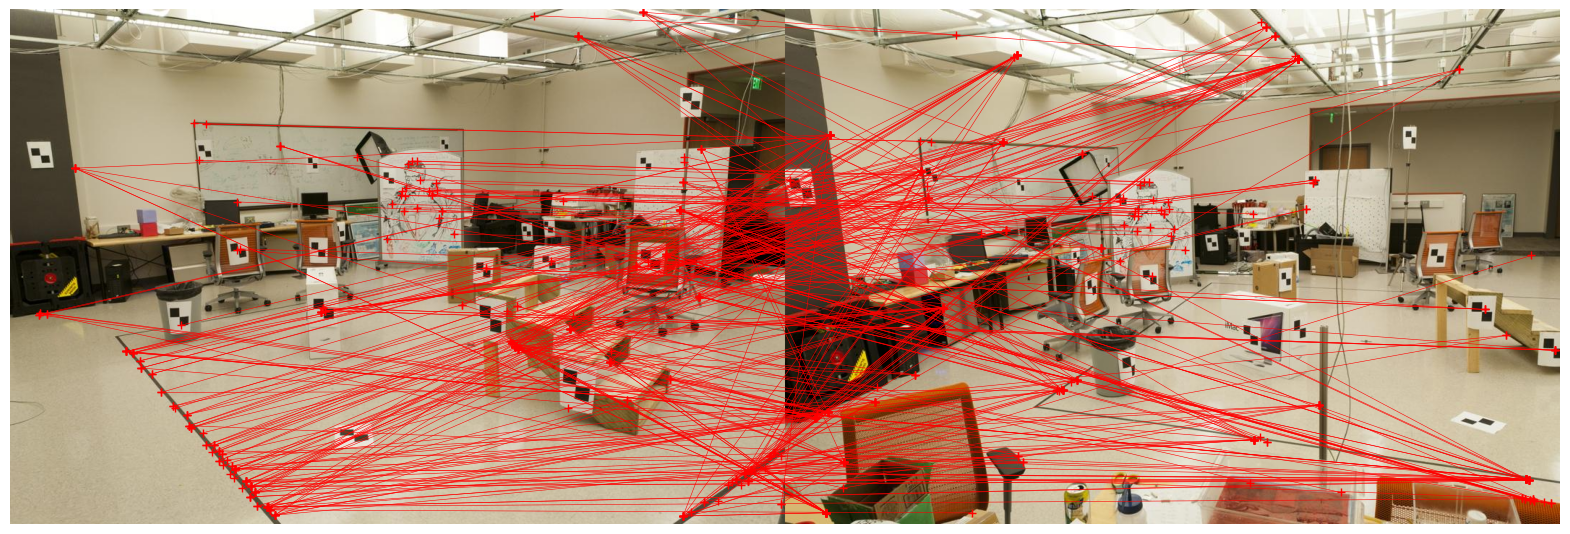

In [35]:
import numpy as np
import matplotlib.pyplot as plt


lab1 = imread('./lab1.jpg')
lab2 = imread('./lab2.jpg')

data = get_best_matches(lab1, lab2, threshold=0.015)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, lab1, lab2, data)
fig.savefig('sift_match_lab.png', bbox_inches='tight')
data = np.unique(data, axis=0)

In [40]:
F, max_inliers, best_model_errors = ransac(data, distance_threshold=2, outlier_ratio=0.8)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)
print(len(max_inliers))
fig.savefig('ransac_lab.png', bbox_inches='tight')
print(max_inliers.shape)

Average residual: 0.6166900879114469
Inliers: [[ 24.47335815 184.43540955  80.07682037 184.40536499]
 [204.52024841 157.5827179  186.12181091 156.13887024]
 [221.14216614 155.13833618 194.27392578 153.92021179]
 [232.46589661 113.49073029 393.04394531  51.33985519]
 [232.97866821 153.44364929 202.99920654 151.68351746]
 [250.6418457  150.87077332 216.70155334 148.10839844]
 [275.35513306 147.11167908 235.87350464 142.99417114]
 [282.75524902 114.90840149 397.87408447  63.6799202 ]
 [287.48468018 145.52958679 245.6723938  140.5553894 ]
 [307.74728394 142.56549072 262.13153076 136.1986084 ]
 [314.06732178 141.67468262 267.57086182 134.88865662]
 [341.79608154 137.66075134 290.96032715 128.74934387]
 [349.28381348 136.63935852 297.32595825 127.20487213]
 [349.28381348 136.63935852 297.32595825 127.20487213]
 [355.83596802 135.70503235 303.29406738 125.66213226]
 [370.1668396  133.729599   316.04986572 122.43399811]
 [377.96963501 132.68559265 322.71670532 120.74717712]
 [417.31893921 127.

Fundamental Normalized
[[-1.13377315e-06  1.55687381e-05 -3.89040871e-03]
 [ 1.07835509e-05 -2.65638358e-06  3.13466221e-02]
 [-2.33026057e-04 -4.30707351e-02  1.00000000e+00]]
lab: residual in frame 2 (normalized method) =  0.5497313255920021
lab: residual in frame 1 (normalized method) =  0.5833496860082279
lab: residual combined   (normalized method) =  0.566540505800115


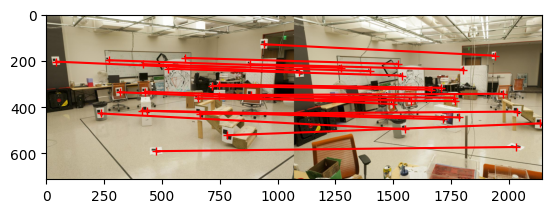

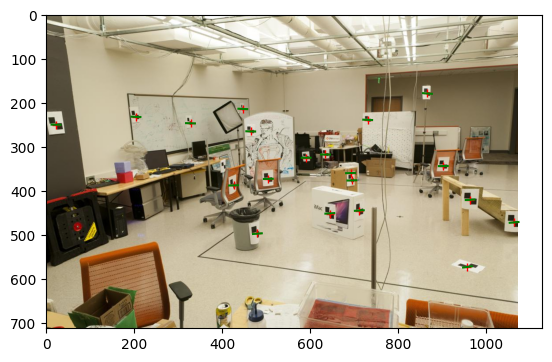

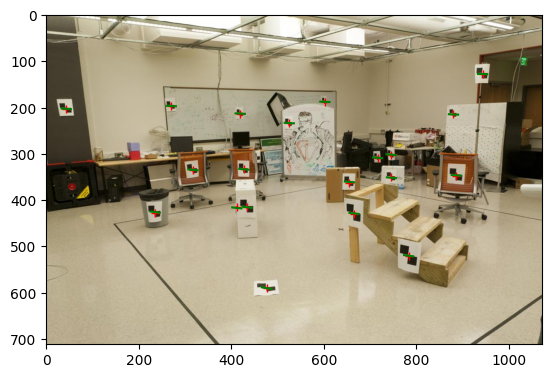

In [37]:
name = 'lab' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
print('Fundamental Normalized')
print(F)
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)

(196, 4)


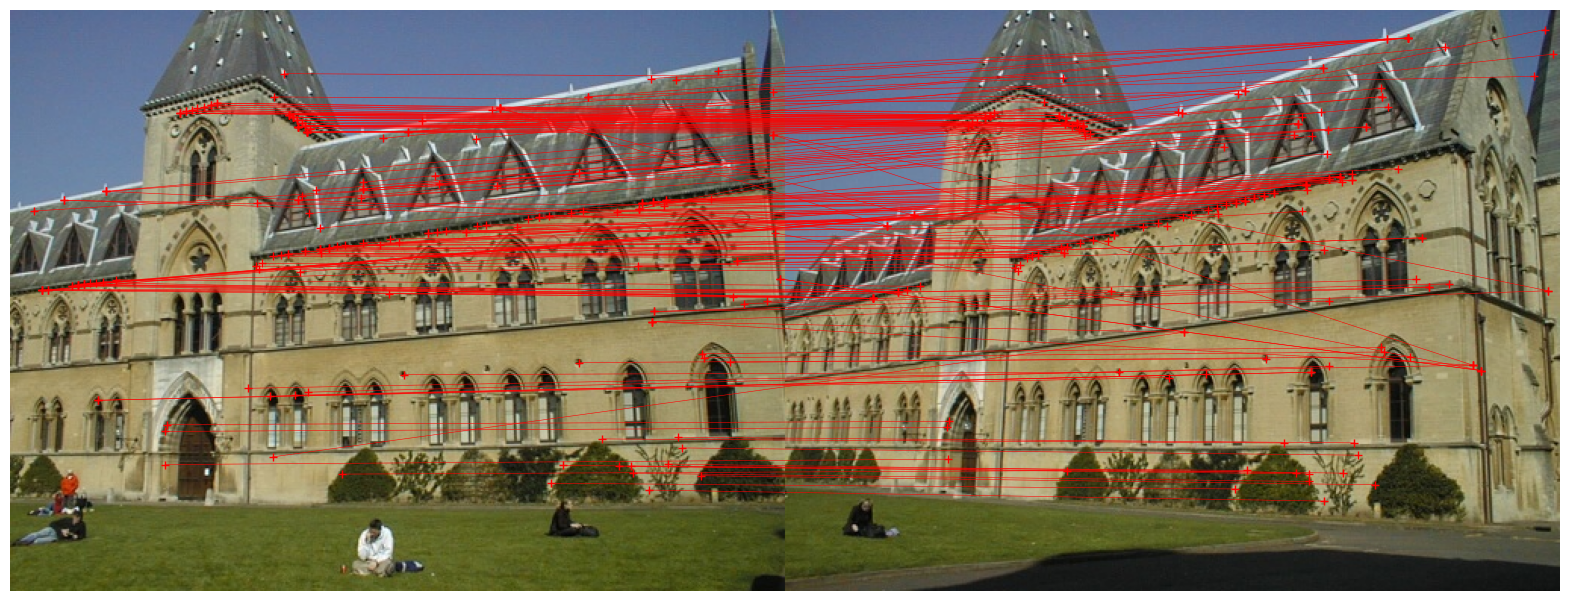

In [38]:
#library
img1 = imread('./library1.jpg')
img2 = imread('./library2.jpg')

data = get_best_matches(img1, img2, threshold=0.03)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match_library.png', bbox_inches='tight')
data = data[np.sum(data, axis=1) != 0]
print(data.shape)

In [39]:
F, max_inliers, best_model_errors = ransac(data, distance_threshold=2, outlier_ratio=0.8)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)
print(len(max_inliers))
fig.savefig('ransac_lab.png', bbox_inches='tight')
print(max_inliers.shape)

Average residual: 0.6717723420426075
Inliers: [[186.55656433  70.66629028 192.29695129  74.37385559]
 [189.11837769  72.54065704 192.29695129  74.37385559]
 [192.32110596  74.51258087 196.31494141  75.98258972]
 [194.09356689 159.12992859 181.98503113 157.19000244]
 [195.61058044  80.35484314 197.27056885  79.88378143]
 [210.13473511 156.76957703 303.29406738 125.66213226]
 [434.40350342 299.68493652 368.27325439 305.64788818]]
7
(7, 4)


Fundamental Normalized
[[ 1.86520131e-07 -3.82943867e-06  5.65229482e-04]
 [ 2.22767397e-05  2.16768623e-07 -4.11451100e-02]
 [-5.30028152e-03  3.69650848e-02  1.00000000e+00]]
library: residual in frame 2 (normalized method) =  0.060334458479578496
library: residual in frame 1 (normalized method) =  0.05484509861965783
library: residual combined   (normalized method) =  0.057589778549618165


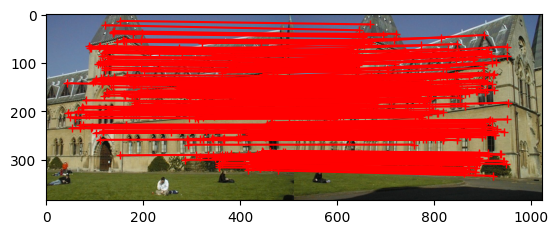

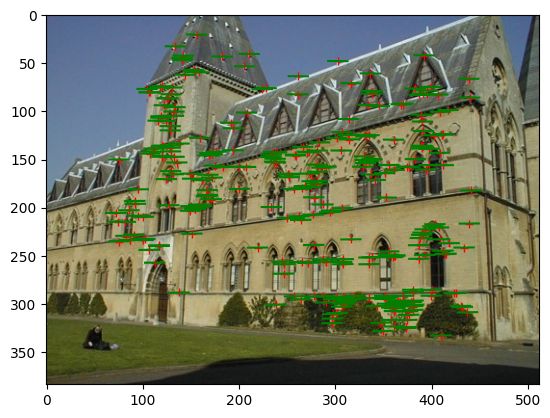

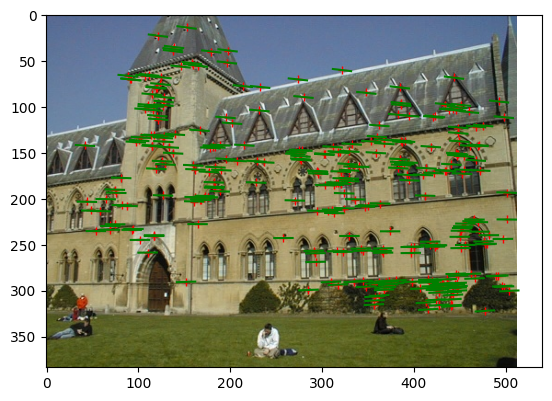

In [41]:
name = 'library' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))


# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
print('Fundamental Normalized')
print(F)
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)